# Motivation 
In this notebook we will load a trained model and use it to detect anomalies in the virtually synthesized anoumalous data. we will then build a heat map to visualize the auc score for different combinations of  anomaly frequency and anomaly amplitude.


In [14]:
# Import Libraries
import sqlite3
import numpy as np
import comet_ml
from config import settings
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd 
from tqdm import tqdm

# Use LaTeX-quality fonts in the plot
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

In [2]:
# Load Settings and Initialize Paths
settings_proc = 'SETTINGS1'
settings_simu = 'SETTINGS1'
root = Path(settings.data.path["processed"])
database_path = (root / settings_simu / settings_simu.lower()).with_suffix('.db')


In [3]:
# Fetch Metadata
from psm.utils.data.metadata import get_metadata_processed
metadata = get_metadata_processed(settings_proc, settings_simu)
freq_axis = metadata['freq']

In [101]:
# Model Loading Paths and Initialization
name_model_1 = 'best-epoch=28-val_loss=2.13.ckpt'
name_model_2 = 'best-epoch=95-val_loss=3.57.ckpt'
model_paths = Path(settings.data.path['model']) / 'model'
model_path_1 = model_paths / name_model_1
model_path_2 = model_paths / name_model_2

from psm.models.vanilla_classification import DenseSignalClassifierModule
model_1 = DenseSignalClassifierModule.load_from_checkpoint(model_path_1)
model_2 = DenseSignalClassifierModule.load_from_checkpoint(model_path_2)

In [102]:
# Anomaly Detection Setup
from psm.models.ad_systems import AD_GMM
ad_gmm_1 = AD_GMM(num_classes=20, model=model_1.model)
ad_gmm_2 = AD_GMM(num_classes=20, model=model_2.model)


In [103]:
# create the dataloader
from psm.models.prepare_data import CreateTransformer,PSDDataModule, PSDNotchDataset, PSDNotchDatasetOriginal

# create the transformer
transformer = CreateTransformer(database_path, freq=freq_axis, freq_min=0, freq_max=150)
transform_psd = transformer.transform_psd
transform_label = transformer.transform_label
dm = PSDDataModule(database_path, transform_psd, transform_label, batch_size=32)
dm.setup()
train_dl = dm.train_dataloader()


(anomaly_level=?) AND stage=? (0, 'train')
(anomaly_level=?) AND stage=? (0, 'test')


In [104]:
ad_gmm_1.fit(train_dl)
ad_gmm_2.fit(train_dl)

In [105]:
from psm.models.prepare_data import PSDDataset
anomaly_psd = PSDDataset(database_path=database_path,
                       transform=transform_psd,
                       transform_label=transform_label,
                       stage='anomaly')
healthy_psd = PSDDataset(database_path=database_path,
                          transform=transform_psd,
                            transform_label=transform_label,
                            stage='healthy')


stage=? ('anomaly',)
stage=? ('healthy',)


In [106]:
from psm.models.prepare_data import PSDDataset_test

In [108]:
psd_test=PSDDataset_test(database_path=database_path,
                       transform=transform_psd, 
                       transform_label=transform_label)



system_name=? ('*',)


In [281]:
# now we have the model, the anommaly data and the normal data. we will use the model to build a control chart and see how it performs. 
# first let's make a df_res dataframe to save the anomaly index 
from torch.utils.data import DataLoader
psd_dl = DataLoader(psd_test,batch_size=10000)

system_name_list, anomaly_index_list, anomaly_level_list, stage_list, excitation_list,latent_list = [],[],[],[],[],[]

for batch in psd_dl:
    psd, system_name, anomaly_level, stage, excitation_amplitude, latent_value = batch
    anomaly_index = ad_gmm_1.predict(psd)

    system_name_list.extend(system_name.tolist())
    anomaly_index_list.extend(anomaly_index.tolist())
    anomaly_level_list.extend(anomaly_level.tolist())
    stage_list.extend(stage)
    excitation_list.extend(excitation_amplitude.tolist())
    latent_list.extend(latent_value.tolist())

df_res = pd.DataFrame({'system_name':system_name_list,
                          'anomaly_index':anomaly_index_list,
                            'anomaly_level':anomaly_level_list,
                            'stage':stage_list,
                            'excitation':excitation_list,
                            'latent':latent_list})



In [195]:
import sys 
eps = sys.float_info.epsilon

In [196]:

LCL

0.9983401903392857

/tmp/ipykernel_35661/1070278282.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res_sys['stage'] = pd.Categorical(df_res_sys['stage'], categories=stage_order, ordered=True)


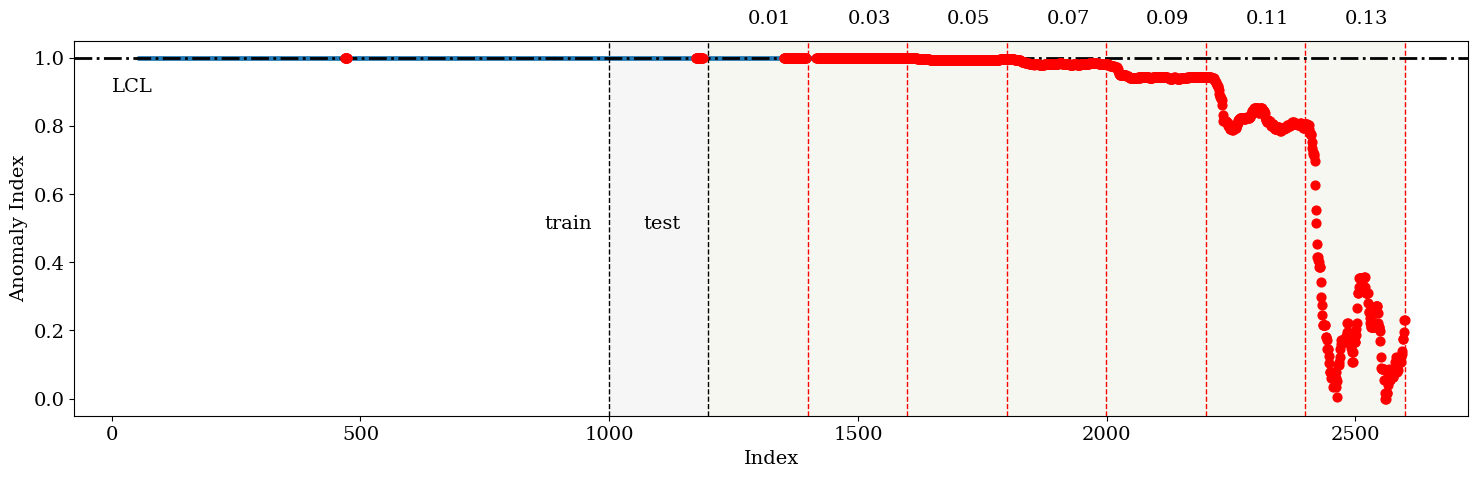

In [403]:
df_res_sys = df_res[df_res['system_name']==5]
stage_order = ['train', 'test', 'anomaly']
df_res_sys['stage'] = pd.Categorical(df_res_sys['stage'], categories=stage_order, ordered=True)

df_res_sys = df_res_sys.sort_values(by=['stage', 'anomaly_level'])
df_res_sys['stage'] = df_res_sys['stage'].astype(str)
#reset the index
df_res_sys = df_res_sys.reset_index(drop=True)
# change index value 
change_stage_indices = df_res_sys[df_res_sys['stage'].shift(-1) != df_res_sys['stage']].index.values[:-1]
change_anomaly_indices = df_res_sys[df_res_sys['anomaly_level'].shift(-1)!=df_res_sys['anomaly_level']].index.values[1:]
dict_stage = dict(zip(change_stage_indices, df_res_sys['stage'].iloc[change_stage_indices]))
dict_anomaly = dict(zip(change_anomaly_indices, df_res_sys['anomaly_level'].iloc[change_anomaly_indices]))


min_max_normalization = lambda x: (x - x.min()) / (x.max() - x.min()) +1
df_res_sys.loc[:, 'anomaly_index'] = min_max_normalization(df_res_sys['anomaly_index'])
df_res_sys.loc[:, 'anomaly_index'] = np.log(df_res_sys['anomaly_index'])
df_res_sys['anomaly_index'] = df_res_sys['anomaly_index'].rolling(50).median()
df_res_sys.loc[:, 'anomaly_index'] = min_max_normalization(df_res_sys['anomaly_index'])-1
std = df_res_sys[df_res_sys['stage'] =='train']['anomaly_index'].std()

std = df_res_sys[df_res_sys['stage'] =='train']['anomaly_index'].std()
mean = df_res_sys[df_res_sys['stage'] =='train']['anomaly_index'].mean()
LCL = mean - 3*std - eps



fig, ax = plt.subplots(figsize=(15, 5))
df_res_sys['anomaly_index'].plot(marker='o', markersize=2, linestyle='', ax=ax, label='anomaly index', alpha=0.7)

# Highlight different stages
colors = ['lightgray', 'lightyellow', 'lightpink']
for idx, color in zip(change_stage_indices, colors):
    ax.axvspan(idx, change_stage_indices[idx+1] if idx+1 < len(change_stage_indices) else df_res_sys.index[-1], facecolor=color, alpha=0.2)

# Change in stage
for k, v in dict_stage.items():
    plt.axvline(x=k, color='k', linestyle='--', linewidth=1)
    plt.text(x=k-130, y=0.5, s=v, rotation=0)

# Anomaly level change
for k, v in dict_anomaly.items():
    plt.axvline(x=k, color='r', linestyle='--', linewidth=1)
    plt.text(x=k-120, y=1.1, s=v, rotation=0)

# LCL
plt.axhline(y=LCL, color='k', linestyle='-.', linewidth=2, label='LCL')
plt.text(x=0, y=LCL-0.1, s='LCL', rotation=0)
below_LCL = df_res_sys['anomaly_index'] < LCL
plt.scatter(df_res_sys[below_LCL].index, df_res_sys[below_LCL]['anomaly_index'], color='red', s=40, marker='o', zorder=2, label='Below LCL')

# Add title and labels
plt.xlabel('Index')
plt.ylabel('Anomaly Index')

plt.tight_layout()
plt.show()


/tmp/ipykernel_35661/2657109244.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_local['stage'] = pd.Categorical(df_local['stage'], categories=stage_order, ordered=True)


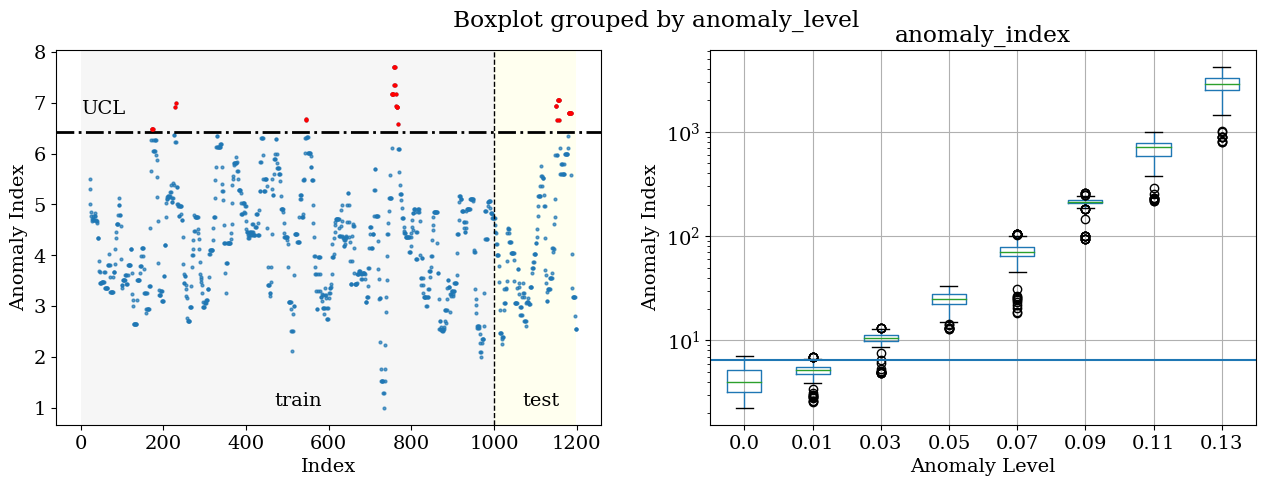

In [404]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Pre-process the dataframe
def preprocess_dataframe(df,system_name:int=6):
    stage_order = ['train', 'test', 'anomaly']
    df_local = df[df['system_name'] == system_name]
    df_local['stage'] = pd.Categorical(df_local['stage'], categories=stage_order, ordered=True)
    df_local = df_local.sort_values(by=['stage', 'anomaly_level'])
    df_local['stage'] = df_local['stage'].astype(str)
    df_local = df_local.reset_index(drop=True)
    
    return df_local

def get_change_indices(df):
    change_stage_indices = df[df['stage'].shift(-1) != df['stage']].index.values[:-1]
    change_anomaly_indices = df[df['anomaly_level'].shift(-1)!=df['anomaly_level']].index.values[1:]
    dict_stage = dict(zip(change_stage_indices, df['stage'].iloc[change_stage_indices]))
    dict_anomaly = dict(zip(change_anomaly_indices, df['anomaly_level'].iloc[change_anomaly_indices]))
    
    return dict_stage, dict_anomaly

def get_CL(df):
    import sys
    eps = sys.float_info.epsilon
    std = df[df['stage'] =='train']['anomaly_index'].std()
    mean = df[df['stage'] =='train']['anomaly_index'].mean()
    LCL = mean - 2*std - eps
    UCL = mean + 2*std + eps
    return UCL

def normalize_anomaly_index(df):
    # smooth the anomaly index
    df.loc[:, 'anomaly_index'] = df['anomaly_index'].rolling(20).median()
    df.loc[:, 'anomaly_index'] = -1 * df['anomaly_index']
    # add the min to make it positive
    df.loc[:, 'anomaly_index'] = df['anomaly_index'] - df['anomaly_index'].min()+1
    return df
def get_ax_bounds(ax):
    return ax.get_xlim(), ax.get_ylim()

def get_ax_middle_y(ax):
    min,max= get_ax_bounds(ax)[1]
    return (min+3*max)/4
def get_ax_range_y(ax):
    min,max= get_ax_bounds(ax)[1]
    return max-min
def get_text_loc(ax):
    min,max= get_ax_bounds(ax)[1]
    loc = min + 0.05*(max-min)
    return loc


def plot_control_chart(df,CL):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    colors=['lightgray', 'lightyellow', 'lightred']
    train_test_df = df[df['stage'] != 'anomaly']
    test_anomaly_df = df[df['stage'] != 'train']
    

    # Plot train and test in timeseries fashion
    train_test_df['anomaly_index'].plot(marker='o', markersize=2, linestyle='', ax=axs[0],  alpha=0.7)
    # plot a line where the test start and color the area
    stage_indice,_ = get_change_indices(train_test_df)
    # Highlight different stages
    colors = ['lightgray', 'lightyellow']
    train_end_idx=train_test_df.index[train_test_df['stage']=='train'][-1]
    test_end_idx=train_test_df.index[train_test_df['stage']=='test'][-1]
    axs[0].axvspan(0, train_end_idx, facecolor=colors[0], alpha=0.2)
    axs[0].axvspan(train_end_idx, test_end_idx, facecolor=colors[1], alpha=0.5)
    # vertical line where the test starts
    axs[0].axvline(x=train_end_idx, color='k', linestyle='--', linewidth=1)
    text_loc = get_text_loc(axs[0])
    mid_test_x = (train_end_idx+test_end_idx)/2
    mid_train_x = (0+train_end_idx)/2

    axs[0].text(x=mid_test_x-30, y=text_loc, s='test', rotation=0)
    axs[0].text(x=mid_train_x-30, y=text_loc, s='train', rotation=0)
    # add UCL
    range_y = get_ax_range_y(axs[0])
    axs[0].axhline(y=CL, color='k', linestyle='-.', linewidth=2, label='UCL')
    axs[0].text(x=0, y=CL+0.05*range_y, s='UCL', rotation=0)
    # color the dots above UCL
    above_UCL = train_test_df['anomaly_index'] > UCL
    axs[0].scatter(train_test_df[above_UCL].index, train_test_df[above_UCL]['anomaly_index'], color='red', s=4, marker='o', zorder=2, label='Above UCL')


    
    get_change_indices(train_test_df)

    axs[0].set_xlabel('Index')
    axs[0].set_ylabel('Anomaly Index')
    
    # plot anomaly with boxplots where are the anomaly levels is the x axis
    test_anomaly_df.boxplot(column='anomaly_index', by='anomaly_level', ax=axs[1])

    axs[1].set_yscale('log')
    axs[1].set_xlabel('Anomaly Level')
    axs[1].set_ylabel('Anomaly Index')
    # add UCL

    range_y = get_ax_range_y(axs[1])
    axs[1].axhline(CL)

    
df_sys = preprocess_dataframe(df_res,system_name=6)
df_sys = normalize_anomaly_index(df_sys)
UCL = get_CL(df_sys)

plot_control_chart(df_sys,CL=UCL)



4358.194048911126


AttributeError: 'Figure' object has no attribute 'title'

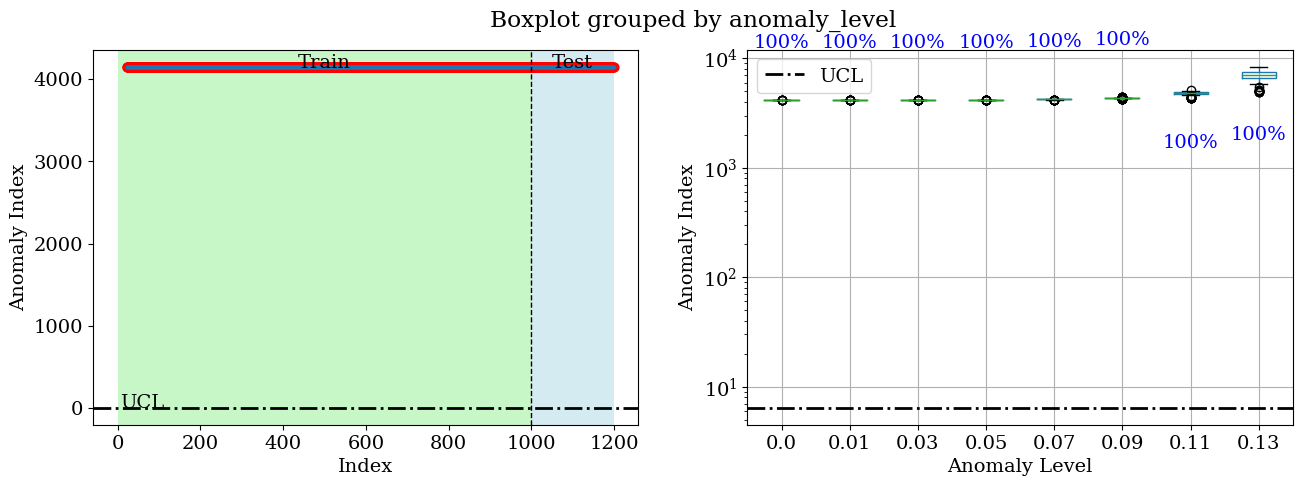

In [402]:
def train_test_text_location(ax):
    min,max= get_ax_bounds(ax)[1]
    loc = min + 0.05*(max-min)
    return loc
def CL_text_location(ax,CL):
    min_y,max_y= get_ax_bounds(ax)[1]
    y_loc = CL + 1e-3*(max_y-min_y)
    min_x, max_x = get_ax_bounds(ax)[0]
    print(max_y)
    x_loc = min_x + 5e-2*(max_x-min_x)
    return {'x':x_loc,'y':y_loc}

def plot_test_train_chart(df, CL,ax):
    train_test_df = df[df['stage'] != 'anomaly']

    train_test_df['anomaly_index'].plot(marker='o', markersize=2, linestyle='', ax=ax, alpha=0.7)
    colors = ['lightgreen', 'lightblue']
    
    train_end_idx = train_test_df.index[train_test_df['stage'] == 'train'][-1]
    test_end_idx = train_test_df.index[train_test_df['stage'] == 'test'][-1]
    
    ax.axvspan(0, train_end_idx, facecolor=colors[0], alpha=0.5)
    ax.axvspan(train_end_idx, test_end_idx, facecolor=colors[1], alpha=0.5)

    ax.axvline(x=train_end_idx, color='k', linestyle='--', linewidth=1)
    text_loc = get_text_loc(ax)
    mid_test_x = (train_end_idx + test_end_idx) / 2
    mid_train_x = train_end_idx / 2

    ax.text(x=mid_test_x, y=text_loc, s='Test', rotation=0, ha='center')
    ax.text(x=mid_train_x, y=text_loc, s='Train', rotation=0, ha='center')
    
    ax.axhline(y=CL, color='k', linestyle='-.', linewidth=2, label='UCL')
    loc_text_CL = CL_text_location(ax,CL)
    ax.text(**loc_text_CL, s='UCL')
    
    above_CL = train_test_df['anomaly_index'] > CL
    ax.scatter(train_test_df[above_CL].index, train_test_df[above_CL]['anomaly_index'], color='red', s=40, marker='o', label='Above CL')

    ax.set_xlabel('Index')
    ax.set_ylabel('Anomaly Index')


def plot_anomaly_boxplot(df, CL,ax):
    test_anomaly_df = df[df['stage'] != 'train']

    test_anomaly_df.boxplot(column='anomaly_index', by='anomaly_level', ax=ax)
    ax.set_yscale('log')
    ax.set_title('Anomaly Levels')
    ax.set_xlabel('Anomaly Level')
    ax.set_ylabel('Anomaly Index')

    ax.axhline(y=CL, color='k', linestyle='-.', linewidth=2, label='UCL')
    groups = test_anomaly_df.groupby('anomaly_level')
    for i, (level, group) in enumerate(groups):
        ratio = sum(group['anomaly_index'] > CL) / len(group)
        # Position the text label slightly above the top whisker of each boxplot
        if i <6:
            top_whisker = group['anomaly_index'].quantile(0.75) + 1.5 * (group['anomaly_index'].quantile(0.75) - group['anomaly_index'].quantile(0.25))
            y_pos = top_whisker * 3
        else:
            bottom_whisker = group['anomaly_index'].quantile(0.25) - 1.5 * (group['anomaly_index'].quantile(0.75) - group['anomaly_index'].quantile(0.25))
            y_pos = bottom_whisker/3
        ax.text(i + 1, y_pos, f"{ratio:.0%}", ha='center', color='blue',rotation=0)  


    # Remove the auto-generated title from the boxplot
    ax.set_title('')

    ax.legend()

def plot_cc(df, CL):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    plot_test_train_chart(df, CL,axs[0])
    plot_anomaly_boxplot(df, CL,axs[1])
    fig.title('Control Chart')

plot_cc(df_sys,CL=UCL)

ValueError: not enough values to unpack (expected 2, got 0)

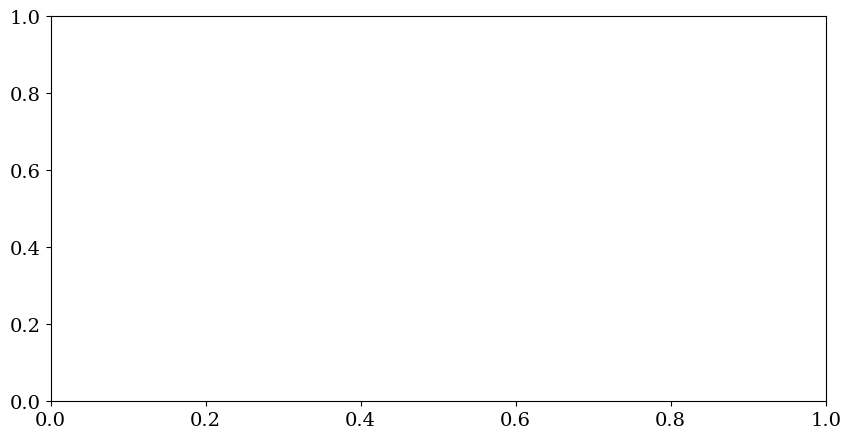

In [401]:
def preprocess_dataframe(df, system_name:int=6):
    stage_order = ['train', 'test', 'anomaly']
    df_local = df[df['system_name'] == system_name].copy()
    df_local['stage'] = df_local['stage'].astype("category").cat.set_categories(stage_order, ordered=True)
    df_local.sort_values(by=['stage', 'anomaly_level'], inplace=True)
    return df_local.reset_index(drop=True)

def get_CL(df):
    eps = np.finfo(float).eps
    std = df[df['stage'] == 'train']['anomaly_index'].std()
    mean = df[df['stage'] == 'train']['anomaly_index'].mean()
    LCL = mean - 2*std - eps
    UCL = mean + 2*std + eps
    return UCL

def normalize_anomaly_index(df):
    df['anomaly_index'] = df['anomaly_index'].rolling(20).median()
    df['anomaly_index'] = (-1 * df['anomaly_index']) - df['anomaly_index'].min() + 1
    return df
def CL_text_location(ax, CL):
    min_y, max_y = get_ax_bounds(ax)[1]
    y_loc = CL + 1e-3 * (max_y - min_y)
    min_x, max_x = get_ax_bounds(ax)[0]
    x_loc = min_x + 5e-2 * (max_x - min_x)
    return {'x': x_loc, 'y': y_loc}

def boxplot_controlchart(df, ax):
    # Preprocess the dataframe
    df = preprocess_dataframe(df)
    
    # Add the 'Training' level for training data
    df.loc[df['stage'] == 'train', 'anomaly_level'] = 'Training'

    # Plot boxplot
    df.boxplot(column='anomaly_index', by='anomaly_level', ax=ax)
    ax.set_yscale('log')
    ax.set_title('Anomaly Levels')
    ax.set_xlabel('Anomaly Level')
    ax.set_ylabel('Anomaly Index')

    # Display UCL line and label
    UCL = get_CL(df)
    ax.axhline(y=UCL, color='k', linestyle='-.', linewidth=2, label='UCL')
    loc_text_CL = CL_text_location(ax, UCL)
    ax.text(**loc_text_CL, s='UCL')
    ax.set_yscale('log')

    # Remove the auto-generated title from the boxplot
    plt.suptitle('')
    ax.legend()

# Sample usage:
fig, ax = plt.subplots(figsize=(10, 5))
df_sys = preprocess_dataframe(df_res, system_name=5)
df_sys = normalize_anomaly_index(df_sys)
boxplot_controlchart(df_sys, ax=ax)



In [ ]:
def pl